In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dmeeting = pd.read_parquet('./data/data_meeting.parquet')
data_agenda1 = pd.read_parquet('./data/data_agenda1.parquet')
data_agenda2 = pd.read_parquet('./data/data_agenda2.parquet')
data_agenda3 = pd.read_parquet('./data/data_agenda3.parquet')
data_speech1 = pd.read_parquet('./data/data_speech1.parquet')
data_speech2 = pd.read_parquet('./data/data_speech2.parquet')
data_speech3 = pd.read_parquet('./data/data_speech3.parquet')
parMem = pd.read_parquet('./data/parliament_members.parquet')

dagenda = pd.concat([data_agenda1, data_agenda2, data_agenda3], axis=0)
dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)

annotation_data = pd.read_csv('data/annotation_data.csv')

## sample speech items from C and NC

In [103]:
annotation_data['Anders_label'].value_counts()

NC    1432
C      100
?       25
Name: Anders_label, dtype: int64

In [104]:
agendaC = annotation_data[annotation_data['Anders_label'] == 'C']
speechC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechC['label'] = 'C'

C:\Users\ah140\AppData\Local\Temp\ipykernel_16980\659953897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speechC['label'] = 'C'


In [105]:
agendaNC = annotation_data[annotation_data['Anders_label'] == 'NC']
speechNC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaNC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechNC = pd.merge(speechNC, agendaNC[['meeting_id', 'agenda_item_id', 'group']], on=['meeting_id', 'agenda_item_id'], how='left')
speechNC['label'] = 'NC'

In [106]:
from sklearn.model_selection import StratifiedKFold

X = [0] * len(speechNC)
nsplits = int(1/(len(speechC)/len(speechNC)))

stratified_kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(stratified_kfold.split(X, speechNC.group.to_list())):
    val_index = list(val_idx)
    speechNC = speechNC.loc[val_index]
    break

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=14.
  warnings.warn(


In [107]:
speechNC = speechNC.drop(columns = 'group')

In [108]:
speech_comb = pd.concat([speechC, speechNC])

In [112]:
speech_comb

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label
20630,98,5,1,13:28:38,13:29:52,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,"Forurenet drikkevand, halvtomme søer og åer, u...",74.0,81,C
20631,98,5,3,13:29:54,13:31:06,Helle Thorning-Schmidt,S,minister,Statsministeren(Helle Thorning-Schmidt):,"Jeg synes, det er godt at tage en debat om, hv...",72.0,133,C
20632,98,5,5,13:31:09,13:32:28,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,"Jeg synes bestemt, det var et skridt i den rig...",79.0,97,C
20633,98,5,7,13:32:30,13:33:17,Helle Thorning-Schmidt,S,minister,Statsministeren(Helle Thorning-Schmidt):,Jeg kan selvfølgelig ikke gå ind i de specifik...,47.0,65,C
20634,98,5,9,13:33:19,13:34:57,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,Men vi har også en fælles beslutning i Folketi...,98.0,90,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36032,1784,12,36,15:47:47,15:48:19,Per Clausen,EL,medlem,Per Clausen(EL):,Det er jo altid dejligt at høre om den her fan...,32.0,68,NC
36057,1786,11,22,15:50:46,15:51:28,Karen Ellemann,V,medlem,Karen Ellemann(V):,"Det er da utrolig glædeligt, at Socialdemokrat...",42.0,102,NC
36068,1786,11,44,16:08:35,16:09:19,Thomas Adelskov,S,medlem,Thomas Adelskov(S):,"Ja, det var en for og en imod. Jeg forstår, at...",44.0,52,NC
36091,1786,12,2,16:42:25,16:45:34,Sophie Løhde,V,medlem,Sophie Løhde(V):,Det danske sundhedsvæsen står over for mange o...,189.0,121,NC


### Try with different frequencies for C and NC and preprocess speech text data

In [ ]:
import spacy
nlp = spacy.load("da_core_news_sm")
from spacy.lang.da.stop_words import STOP_WORDS

In [402]:
exception_list = ['CO2', 'co2']
def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens

In [403]:
def word_to_vec(word):
    return nlp(word).vector

In [404]:
speechC["processed_tokens"] = speechC.speech_item_text.apply(preprocess_text)
speechNC["processed_tokens"] = speechNC.speech_item_text.apply(preprocess_text)

C:\Users\ah140\AppData\Local\Temp\ipykernel_16980\2027690526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speechC["processed_tokens"] = speechC.speech_item_text.apply(preprocess_text)


In [427]:
speechC

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label,processed_tokens
20630,98,5,1,13:28:38,13:29:52,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,"Forurenet drikkevand, halvtomme søer og åer, u...",74.0,81,C,"[forurene, drikkevand, halvtom, søer, åer, uds..."
20631,98,5,3,13:29:54,13:31:06,Helle Thorning-Schmidt,S,minister,Statsministeren(Helle Thorning-Schmidt):,"Jeg synes, det er godt at tage en debat om, hv...",72.0,133,C,"[god, tage, debat, komme, frem, mod, grøn, oms..."
20632,98,5,5,13:31:09,13:32:28,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,"Jeg synes bestemt, det var et skridt i den rig...",79.0,97,C,"[bestemt, skridt, rigtig, retning, statsminist..."
20633,98,5,7,13:32:30,13:33:17,Helle Thorning-Schmidt,S,minister,Statsministeren(Helle Thorning-Schmidt):,Jeg kan selvfølgelig ikke gå ind i de specifik...,47.0,65,C,"[selvfølgelig, gå, specifikke, miljøkrav, tro,..."
20634,98,5,9,13:33:19,13:34:57,Pia Olsen Dyhr,SF,medlem,Pia Olsen Dyhr(SF):,Men vi har også en fælles beslutning i Folketi...,98.0,90,C,"[fælles, beslutning, folketing, naturgas, danm..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367772,1776,17,97,16:45:02,16:46:06,Per Ørum Jørgensen,KF,medlem,Per Ørum Jørgensen(KF):,"Jeg tror ikke, hr. Per Clausen kan bestride, a...",64.0,52,C,"[tro, per, clausen, bestride, tradition, indgå..."
367773,1776,17,99,16:46:10,16:46:59,Per Clausen,EL,medlem,Per Clausen(EL):,"Jeg synes alligevel, det er lidt interessant, ...",49.0,51,C,"[interessant, når, forsøge, diskussion, per, ø..."
367774,1776,17,101,16:47:01,16:47:49,Per Ørum Jørgensen,KF,medlem,Per Ørum Jørgensen(KF):,Nu kan man jo tolke og konkludere på mange måd...,48.0,23,C,"[tolke, konkludere, måde, lovpriste, statsmini..."
367775,1776,17,103,16:48:04,16:53:28,Johs. Poulsen,RV,medlem,Johs. Poulsen(RV):,"Det Radikale Venstre har en vision om, at vi i...",324.0,43,C,"[radikal, venstre, vision, inden, generation, ..."


### Odds

In [405]:
unique_words_list_C = []
unique_words_list_NC = []
for i in range(len(speechC)):
    unique_words_list_C.extend(speechC.processed_tokens.iloc[i])
for i in range(len(speechNC)):
    unique_words_list_NC.extend(speechNC.processed_tokens.iloc[i])

unique_words_list_C = Counter(unique_words_list_C)
unique_words_C_df= pd.DataFrame.from_dict(unique_words_list_C, orient='index', columns = ['Frequency_C'])
unique_words_C_df.reset_index(inplace=True)
unique_words_C_df.rename(columns={'index': 'word'}, inplace=True)

unique_words_list_NC = Counter(unique_words_list_NC)
unique_words_NC_df= pd.DataFrame.from_dict(unique_words_list_NC, orient='index', columns = ['Frequency_NC'])
unique_words_NC_df.reset_index(inplace=True)
unique_words_NC_df.rename(columns={'index': 'word'}, inplace=True)

In [406]:
def caluc_proportion(freqC, freqNC):
    if freqNC == 0:
        if freqC == 0:
            return 0
        else:
            return freqC
    else:
        if freqC == 0:
            return 0
        else:
            return freqC/freqNC

In [413]:
merged_words = pd.merge(unique_words_C_df, unique_words_NC_df, on='word', how='outer')
merged_words[['Frequency_C', 'Frequency_NC']] = merged_words[['Frequency_C', 'Frequency_NC']].fillna(0)
merged_words["odds"] = merged_words.apply(lambda row: caluc_proportion(row['Frequency_C'], row['Frequency_NC']), axis=1)
merged_words['vector'] = merged_words['word'].apply(word_to_vec)
merged_words["pos"] = merged_words.word.apply(lambda x: nlp(x)[0].pos_)

In [429]:
def count_speech_item_appearance(word, df):
    count = 0
    for i in range(len(df)):
        if word in df.processed_tokens.iloc[i]:
            count += 1
    
    return count

In [430]:
merged_words["app_count_C"] = merged_words.word.apply(lambda x: count_speech_item_appearance(x, speechC))
merged_words["app_count_NC"] = merged_words.word.apply(lambda x: count_speech_item_appearance(x, speechNC))

In [445]:
def calcu_weighted_odds(freqC, freqNC, app_count_C, app_count_NC):
    if app_count_NC == 0:
        return freqC*app_count_C
    else:
        return (freqC*app_count_C)/(freqNC*app_count_NC)

In [446]:
merged_words['weighted_odds'] = merged_words.apply(lambda row: calcu_weighted_odds(row['Frequency_C'], row['Frequency_NC'], row['app_count_C'], row['app_count_NC']), axis=1)

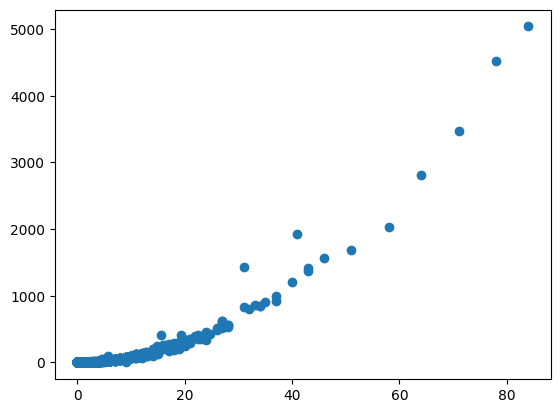

In [447]:
plt.scatter(merged_words['odds'], merged_words['weighted_odds'])

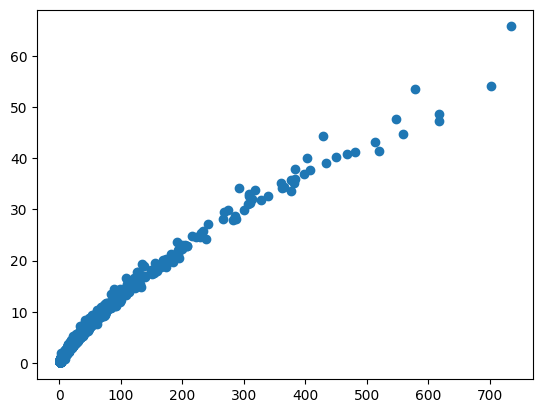

In [500]:
plt.scatter(mergedd_words['Frequency_C'], mergedd_words['tf_idfC'])

In [499]:
mergedd_words = pd.merge(merged_words, tf, on='word', how='left')
mergedd_words.sort_values('tf_idfC', ascending=False)[0:40]

,word,Frequency_C,Frequency_NC,odds,vector,pos,app_count_C,app_count_NC,weighted_odds,tf_idfC
35,tak,734.0,732.0,1.002732,"[-3.109055, -3.697621, 0.96369493, -1.0557451,...",NOUN,620,619,1.004352,65.727266
248,se,701.0,768.0,0.912760,"[-0.1210264, 1.9409842, -0.2466302, 2.9634686,...",VERB,551,595,0.845262,54.192878
204,ordfører,578.0,577.0,1.001733,"[-1.5271475, -4.557616, 1.9805547, -0.96325374...",NOUN,386,393,0.983891,53.437921
33,sige,617.0,689.0,0.895501,"[1.4490554, 1.0370467, 3.9697628, 2.9417734, 1...",VERB,505,522,0.866337,48.707285
50,regering,547.0,542.0,1.009225,"[-1.9171503, -3.2931569, -1.1523192, 0.8818500...",NOUN,401,397,1.019394,47.705092
264,når,618.0,676.0,0.914201,"[-2.3185878, -1.7460213, 2.1982663, 1.2371192,...",SCONJ,525,547,0.877433,47.180654
123,bare,559.0,525.0,1.064762,"[6.541895, -6.488294, 2.215279, -0.7331236, -2...",ADV,469,441,1.132366,44.804763
152,minister,428.0,505.0,0.847525,"[-2.994966, -2.3806388, -2.1956043, -3.5068698...",NOUN,285,290,0.832912,44.271672
120,danmark,513.0,460.0,1.115217,"[0.17387623, -4.551032, -2.1313777, -0.4120212...",PROPN,375,344,1.215717,43.110118
102,altså,519.0,574.0,0.904181,"[2.8791776, -2.9024794, 3.1254153, -1.0399576,...",ADV,451,501,0.813944,41.387940


In [450]:
merged_words.sort_values('odds', ascending=False)[0:40]

,word,Frequency_C,Frequency_NC,odds,vector,pos,app_count_C,app_count_NC,weighted_odds
3542,plantebasere,84.0,0.0,84.000000,"[-2.2599342, -2.1011493, 0.9913131, 0.6835394,...",VERB,60,0,5040.000000
3533,kost,78.0,0.0,78.000000,"[-3.3780243, -0.9222176, -1.946459, 0.61105406...",NOUN,58,0,4524.000000
4190,klimarådet,71.0,0.0,71.000000,"[-1.2770069, 1.0721173, 1.1276091, -1.4321704,...",NOUN,49,0,3479.000000
3484,plantebaseret,64.0,0.0,64.000000,"[2.673662, 0.08215022, -1.384927, 0.11793178, ...",VERB,44,0,2816.000000
1617,skov,116.0,2.0,58.000000,"[-3.3916807, -4.350775, -2.7692714, -0.1753463...",NOUN,70,2,2030.000000
5536,øresund,51.0,1.0,51.000000,"[-5.8053026, -0.24326342, -0.94604635, 0.69338...",NOUN,33,1,1683.000000
4485,vindmølle,46.0,0.0,46.000000,"[0.9845276, -2.562399, 2.0965612, 4.3185673, 2...",VERB,34,0,1564.000000
2473,biomasse,43.0,0.0,43.000000,"[-1.1274021, 4.2492824, -2.2499812, -2.1012733...",NOUN,33,0,1419.000000
3129,klimalov,43.0,0.0,43.000000,"[-1.739336, -2.6229162, -4.5768557, 2.522355, ...",PROPN,32,0,1376.000000
1300,energi,123.0,3.0,41.000000,"[-2.2798758, -3.2586625, -1.837513, 4.68293, 6...",NOUN,94,2,1927.000000


In [448]:
merged_words.sort_values('weighted_odds', ascending=False)[0:30]

,word,Frequency_C,Frequency_NC,odds,vector,pos,app_count_C,app_count_NC,weighted_odds
3542,plantebasere,84.0,0.0,84.0,"[-2.2599342, -2.1011493, 0.9913131, 0.6835394,...",VERB,60,0,5040.0
3533,kost,78.0,0.0,78.0,"[-3.3780243, -0.9222176, -1.946459, 0.61105406...",NOUN,58,0,4524.0
4190,klimarådet,71.0,0.0,71.0,"[-1.2770069, 1.0721173, 1.1276091, -1.4321704,...",NOUN,49,0,3479.0
3484,plantebaseret,64.0,0.0,64.0,"[2.673662, 0.08215022, -1.384927, 0.11793178, ...",VERB,44,0,2816.0
1617,skov,116.0,2.0,58.0,"[-3.3916807, -4.350775, -2.7692714, -0.1753463...",NOUN,70,2,2030.0
1300,energi,123.0,3.0,41.0,"[-2.2798758, -3.2586625, -1.837513, 4.68293, 6...",NOUN,94,2,1927.0
5536,øresund,51.0,1.0,51.0,"[-5.8053026, -0.24326342, -0.94604635, 0.69338...",NOUN,33,1,1683.0
4485,vindmølle,46.0,0.0,46.0,"[0.9845276, -2.562399, 2.0965612, 4.3185673, 2...",VERB,34,0,1564.0
4502,køkken,62.0,2.0,31.0,"[-5.5595775, -0.18446401, -1.4025316, -0.66915...",NOUN,46,1,1426.0
2473,biomasse,43.0,0.0,43.0,"[-1.1274021, 4.2492824, -2.2499812, -2.1012733...",NOUN,33,0,1419.0


In [438]:
merged_words[merged_words['odds']>2].sort_values('app_count_C', ascending=False)[0:60]

,word,Frequency_C,Frequency_NC,odds,vector,pos,app_count_C,app_count_NC
44,grøn,306.0,40.0,7.650000,"[-1.1405923, 2.8912263, -1.2191019, 3.4259212,...",ADJ,205,30
1257,mål,155.0,38.0,4.078947,"[-3.5707965, 0.4876126, -0.2058529, 1.1344682,...",NOUN,115,28
840,nå,111.0,46.0,2.413043,"[-3.186232, 4.627596, -0.6842382, 1.3602554, -...",VERB,95,38
1300,energi,123.0,3.0,41.000000,"[-2.2798758, -3.2586625, -1.837513, 4.68293, 6...",NOUN,94,2
45,omstilling,123.0,13.0,9.461538,"[-1.0259875, -4.5114117, -0.699466, 0.60058355...",NOUN,92,10
15,natur,116.0,19.0,6.105263,"[-2.9005666, -4.333987, 2.718253, 0.7570321, 7...",NOUN,89,17
1479,landbrug,133.0,9.0,14.777778,"[1.8719792, 4.3631716, -2.045591, 1.137874, 3....",NOUN,85,5
1551,per,114.0,7.0,16.285714,"[-2.7516851, -2.2185736, -3.6994867, -2.251193...",PROPN,82,5
1617,skov,116.0,2.0,58.000000,"[-3.3916807, -4.350775, -2.7692714, -0.1753463...",NOUN,70,2
1469,reducere,80.0,7.0,11.428571,"[-0.10611874, -3.9057977, -0.9507464, -4.12486...",ADJ,69,6


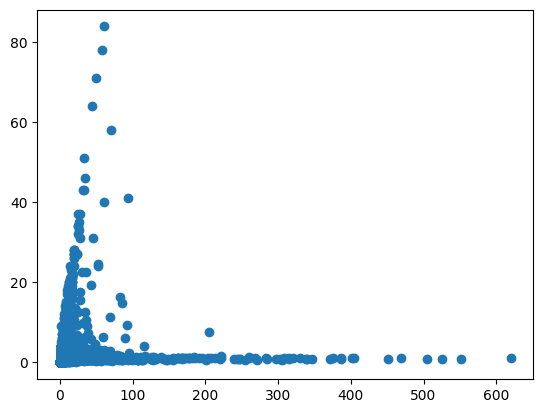

In [436]:
plt.scatter(merged_words['app_count_C'], merged_words['odds'])

In [433]:
merged_words.loc[merged_words['odds']>=3, "pos"].value_counts()

NOUN     664
VERB     153
ADJ      143
PROPN     56
ADV       46
X         21
PRON       4
ADP        4
NUM        4
SYM        2
DET        1
AUX        1
Name: pos, dtype: int64

In [422]:
merged_words[merged_words['odds']>1].describe()

,Frequency_C,Frequency_NC,odds
count,2802.000000,2802.000000,2802.000000
mean,13.519986,7.579586,3.651821
std,39.095126,34.902878,5.080079
min,2.000000,0.000000,1.001733
25%,2.000000,0.000000,2.000000
50%,4.000000,1.000000,2.000000
75%,10.000000,3.000000,4.000000
max,734.000000,732.000000,84.000000


In [399]:
merged_words.loc[merged_words.Frequency_NC!0, 'odds'].describe()

count    6441.000000
mean        0.520855
std         1.903813
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max        58.000000
Name: odds, dtype: float64

(array([4.464e+03, 2.370e+02, 3.090e+02, 1.530e+02, 8.900e+01, 5.310e+02,
        7.300e+01, 7.800e+01, 3.900e+01, 1.100e+01, 1.560e+02, 1.100e+01,
        2.300e+01, 1.300e+01, 5.000e+00, 7.200e+01, 8.000e+00, 1.400e+01,
        1.000e+00, 3.300e+01]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <BarContainer object of 20 artists>)

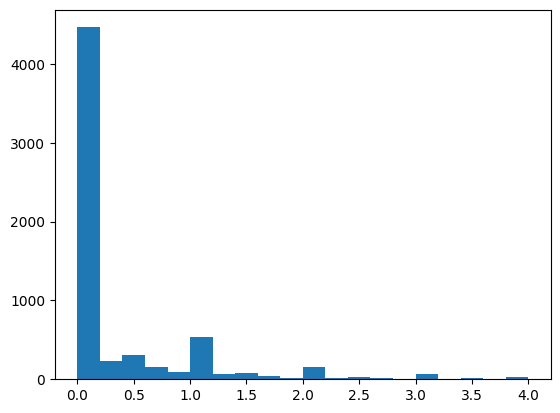

In [400]:
plt.hist(merged_words.loc[merged_words.Frequency_NC!=0, 'odds'], bins=20, range=(0, 4))

In [325]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

data = merged_words['vector'].to_numpy()
data = np.array([np.array(arr) for arr in data])
scaler = StandardScaler()
data = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(data)

temp_unique_words_df['group'] = kmeans.labels_

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ah140\AppData\Local\Temp\ipykernel_16980\2325741215.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_unique_words_df['group'] = kmeans.labels_


c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ah140\AppData\Local\Temp\ipykernel_16980\1416577769.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_unique_words_df['group'] = kmeans.fit_predict(embedded_data)


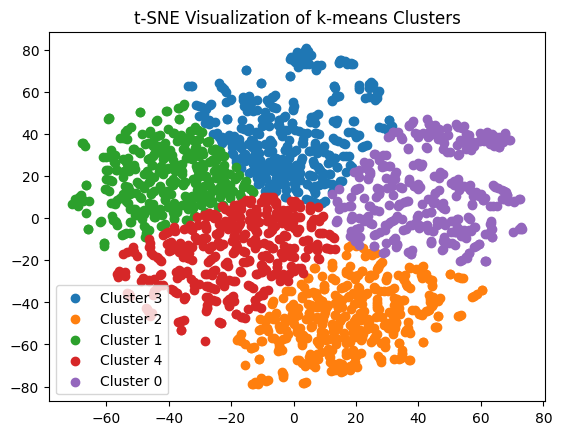

In [336]:

# Assuming temp_unique_words_df['vector'] contains your vector data

# Convert 'vector' column to NumPy array
data = np.array(temp_unique_words_df['vector'].to_list())

# Perform t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=min(7, len(data) - 1))
embedded_data = tsne.fit_transform(data)

# Specify the number of clusters (k) for k-means on t-SNE embeddings
num_clusters = 5  # You can adjust this based on your data

# Perform k-means clustering on t-SNE embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
temp_unique_words_df['group'] = kmeans.fit_predict(embedded_data)

# Scatter plot
for group in temp_unique_words_df['group'].unique():
    plt.scatter(embedded_data[temp_unique_words_df['group'] == group, 0],
                embedded_data[temp_unique_words_df['group'] == group, 1],
                label=f'Cluster {group}')

plt.title('t-SNE Visualization of k-means Clusters')
plt.legend()
plt.show()
